# Linear models with CNN features

## why convbattle2 dataset ?
convbattle fas major defaults :
1. some pict were representing anything but shoes
1. some shoes were really too small on standing people pict to be recognized
1. but, moreover, the dataset is hugely biased, validation set comes from pinterest, train from zappos and google

how to build convbattle2 ?
1. removing bad pict
1. shuffling datasets

In [1]:
from __future__ import division, print_function
# Rather than importing everything manually, we'll make things easy
#   and load them all in utils.py, and just import them from there.
%matplotlib inline
from importlib import reload  # Python 3
import utils; reload(utils)
from utils import *

WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: Tesla K80 (CNMeM is disabled, cuDNN 5110)
Using TensorFlow backend.


In [2]:
import os, json
from glob import glob
import numpy as np
import scipy
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix
np.set_printoptions(precision=4, linewidth=100)
from matplotlib import pyplot as plt
from utils import plots, get_batches, plot_confusion_matrix, get_data

In [3]:
from numpy.random import random, permutation
from scipy import misc, ndimage
from scipy.ndimage.interpolation import zoom

import keras
from keras import backend as K
from keras.utils.data_utils import get_file
from keras.models import Sequential
from keras.layers import Input
from keras.layers.core import Flatten, Dense, Dropout, Lambda
from keras.layers.convolutional import Conv2D, MaxPooling2D, ZeroPadding2D
from keras.optimizers import SGD, RMSprop
from keras.preprocessing import image

In [4]:
import bcolz
def save_array(fname, arr): c=bcolz.carray(arr, rootdir=fname, mode='w'); c.flush()
def load_array(fname): return bcolz.open(fname)[:]

In [5]:
def onehot(x): return np.array(OneHotEncoder().fit_transform(x.reshape(-1,1)).todense())

In [6]:
def plots_idx(idx, titles=None):
    plots([image.load_img(path + 'valid/' + filenames[i]) for i in idx], titles=titles)

In [7]:
#shape dim th patch
from keras import backend as K
K.set_image_dim_ordering('th')

## Train linear model on predictions

In [8]:
path = "convbattle2/"
model_path = path + 'models/'
if not os.path.exists(model_path): os.mkdir(model_path)

In [9]:
#batch_size=256 => KO
batch_size=128
#batch_size=64
#batch_size=4

We need to start with our VGG 16 model, since we'll be using its predictions and features.

In [10]:
from vgg16 import Vgg16
vgg = Vgg16()
model = vgg.model

In [11]:
# Use batch size of 1 since we're just doing preprocessing on the CPU
val_batches = get_batches(path+'valid', shuffle=False, batch_size=1)
batches = get_batches(path+'train', shuffle=False, batch_size=1)

Found 551 images belonging to 2 classes.
Found 2213 images belonging to 2 classes.


In [12]:
#usefull for pict plotting
filenames = val_batches.filenames

We have provided a simple function that joins the arrays from all the batches - let's use this to grab the training and validation data:

In [13]:
val_data = get_data(path+'valid')

Found 551 images belonging to 2 classes.


In [14]:
trn_data = get_data(path+'train')

Found 2213 images belonging to 2 classes.


In [15]:
trn_data.shape

(2213, 224, 224, 3)

In [17]:
save_array(model_path+ 'train_data.bc', trn_data)
save_array(model_path + 'valid_data.bc', val_data)

We can load our training and validation data later without recalculating them:

##### as we have saved data.bc, we can skip get_batches and get_data

In [18]:
#trn_data = load_array(model_path+'train_data.bc')
#val_data = load_array(model_path+'valid_data.bc')

#dim shape patch roll axis from array_shape=(None, 3, 224, 224) to array_shape=(2378, 224, 224, 3)
#TF complient predictions

trn_data = np.rollaxis(load_array(model_path+'train_data.bc'), 3, 1)
val_data = np.rollaxis(load_array(model_path+'valid_data.bc'), 3, 1)

In [19]:
val_data.shape

(551, 3, 224, 224)

In [20]:
val_classes = val_batches.classes
trn_classes = batches.classes
val_labels = onehot(val_classes)
trn_labels = onehot(trn_classes)

## Retrain last layer's linear model

In [21]:
model.pop()
for layer in model.layers: layer.trainable=False

In [22]:
model.add(Dense(2, activation='softmax'))

In [23]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_1 (Lambda)            (None, 3, 224, 224)       0         
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 3, 226, 226)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 224, 224)      1792      
_________________________________________________________________
zero_padding2d_2 (ZeroPaddin (None, 64, 226, 226)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 224, 224)      36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 112, 112)      0         
_________________________________________________________________
zero_padding2d_3 (ZeroPaddin (None, 64, 114, 114)      0         
__________

In [24]:
batches = get_batches(path+'train', shuffle=True, batch_size=1)

Found 2213 images belonging to 2 classes.


In [25]:
vgg.finetune(batches)

...and compile our updated model, and set up our batches to use the preprocessed images (note that now we will also *shuffle* the training batches, to add more randomness when using multiple epochs):

In [26]:
gen=image.ImageDataGenerator()
batches = gen.flow(trn_data, trn_labels, batch_size=batch_size, shuffle=True)
val_batches = gen.flow(val_data, val_labels, batch_size=batch_size, shuffle=False)
steps_per_epoch = int(np.ceil(batches.n/batch_size))
validation_steps = int(np.ceil(val_batches.n/batch_size))

In [27]:
print(trn_labels.shape)
print(val_labels.shape)

(2213, 2)
(551, 2)


In [28]:
print("batch size:" + str(batch_size))
print("calculated steps_per_epoch:" + str(steps_per_epoch) + " | calculated validation_steps:" + str(validation_steps))

batch size:128
calculated steps_per_epoch:18 | calculated validation_steps:5


We'll define a simple function for fitting models, just to save a little typing...

In [29]:
def fit_model(model, batches, val_batches, nb_epoch=1):
    model.fit_generator(batches, steps_per_epoch=steps_per_epoch, epochs=nb_epoch, 
                        validation_data=val_batches, validation_steps=validation_steps)

In [30]:
opt = RMSprop(lr=0.0003)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

#### skipping next steps => loading weights previous 18th epoch

In [32]:
## << skipped >> ##
fit_model(model, batches, val_batches, nb_epoch=2)

Epoch 1/2
18/18 [==============================] - 65s - loss: 1.2178 - acc: 0.5836 - val_loss: 0.6148 - val_acc: 0.7078
Epoch 2/2
18/18 [==============================] - 48s - loss: 0.8610 - acc: 0.6830 - val_loss: 0.6122 - val_acc: 0.7514


In [33]:
## << skipped >> ##
#lets execute 2 more epoch
fit_model(model, batches, val_batches, nb_epoch=2)

Epoch 1/2
18/18 [==============================] - 48s - loss: 0.7817 - acc: 0.7115 - val_loss: 0.5149 - val_acc: 0.7804
Epoch 2/2
18/18 [==============================] - 48s - loss: 0.6760 - acc: 0.7399 - val_loss: 0.4944 - val_acc: 0.7877


In [34]:
## << skipped >> ##
model.save_weights(model_path+'finetune.BS128.LR0003.epoch4.h5')

In [35]:
## << skipped >> ##
#lets execute 2 more epoch
fit_model(model, batches, val_batches, nb_epoch=2)

Epoch 1/2
18/18 [==============================] - 48s - loss: 0.6690 - acc: 0.7709 - val_loss: 0.4619 - val_acc: 0.8167
Epoch 2/2
18/18 [==============================] - 48s - loss: 0.6513 - acc: 0.7727 - val_loss: 0.4359 - val_acc: 0.8149


In [36]:
## << skipped >> ##
#lets execute 2 more epoch
fit_model(model, batches, val_batches, nb_epoch=2)

Epoch 1/2
18/18 [==============================] - 48s - loss: 0.6070 - acc: 0.7657 - val_loss: 0.4353 - val_acc: 0.8330
Epoch 2/2
18/18 [==============================] - 48s - loss: 0.5559 - acc: 0.7875 - val_loss: 0.4575 - val_acc: 0.8258


In [37]:
## << skipped >> ##
model.save_weights(model_path+'finetune.BS128.LR0003.epoch8.h5')

In [38]:
## << skipped >> ##
#lets execute 2 more epoch
fit_model(model, batches, val_batches, nb_epoch=2)

Epoch 1/2
18/18 [==============================] - 48s - loss: 0.5352 - acc: 0.8011 - val_loss: 0.4159 - val_acc: 0.8348
Epoch 2/2
18/18 [==============================] - 48s - loss: 0.5312 - acc: 0.8018 - val_loss: 0.4126 - val_acc: 0.8403


In [39]:
## << skipped >> ##
#lets execute 2 more epoch
fit_model(model, batches, val_batches, nb_epoch=2)

Epoch 1/2
18/18 [==============================] - 49s - loss: 0.4992 - acc: 0.8153 - val_loss: 0.4025 - val_acc: 0.8367
Epoch 2/2
18/18 [==============================] - 49s - loss: 0.4783 - acc: 0.8195 - val_loss: 0.4135 - val_acc: 0.8367


In [40]:
## << skipped >> ##
model.save_weights(model_path+'finetune.BS128.LR0003.epoch12.h5')

In [41]:
## << skipped >> ##
#lets execute 2 more epoch
fit_model(model, batches, val_batches, nb_epoch=2)

Epoch 1/2
18/18 [==============================] - 48s - loss: 0.4644 - acc: 0.8250 - val_loss: 0.3901 - val_acc: 0.8312
Epoch 2/2
18/18 [==============================] - 48s - loss: 0.4524 - acc: 0.8224 - val_loss: 0.3809 - val_acc: 0.8512


In [42]:
## << skipped >> ##
#lets execute 2 more epoch
fit_model(model, batches, val_batches, nb_epoch=2)

Epoch 1/2
18/18 [==============================] - 49s - loss: 0.4224 - acc: 0.8382 - val_loss: 0.3902 - val_acc: 0.8530
Epoch 2/2
18/18 [==============================] - 49s - loss: 0.4607 - acc: 0.8292 - val_loss: 0.3869 - val_acc: 0.8512


batch size = 128
learning rate = 0.0003 >>> maybe too small !!!

#### notes
* epoch 1 = underfitting (acc: 0.5836 VS val_acc: 0.7078)
* epoch 2 = underfitting (acc: 0.6830 VS val_acc: 0.7514)
* epoch 3 to 16 = underfitting

##### don't forget to save weights sometimes

In [44]:
## << skipped >> ##
K.set_value(opt.lr, 0.003)
model.save_weights(model_path+'finetune.BS128.LR0003.epoch16.h5')

In [45]:
## << skipped >> ##
#lets execute 2 more epoch
fit_model(model, batches, val_batches, nb_epoch=2)

Epoch 1/2
18/18 [==============================] - 48s - loss: 2.1876 - acc: 0.6932 - val_loss: 1.3922 - val_acc: 0.7296
Epoch 2/2
18/18 [==============================] - 49s - loss: 1.1677 - acc: 0.7752 - val_loss: 2.2063 - val_acc: 0.6679


* update learning rate to 0.003 => quick overfitting
* reload previous weights and learning rate

In [46]:
## << skipped >> ##
K.set_value(opt.lr, 0.0003)
model.load_weights(model_path+'finetune.BS128.LR0003.epoch16.h5')

In [47]:
## << skipped >> ##
#lets execute 2 more epoch
fit_model(model, batches, val_batches, nb_epoch=2)

Epoch 1/2
18/18 [==============================] - 48s - loss: 0.3915 - acc: 0.8397 - val_loss: 0.4065 - val_acc: 0.8312
Epoch 2/2
18/18 [==============================] - 49s - loss: 0.4001 - acc: 0.8428 - val_loss: 0.3633 - val_acc: 0.8439


* epoch 17 overfitted : acc: 0.8397 > val_acc: 0.8312
* epoch 18 ok : acc: 0.8428 ~ val_acc: 0.8439
* => could run some more epochs (1 or 2)

In [48]:
## << skipped >> ##
model.save_weights(model_path+'finetune.BS128.LR0003.epoch18.h5')

#### end of skipped part

In [34]:
K.set_value(opt.lr, 0.0003)
model.load_weights(model_path+'finetune.BS128.LR0003.epoch18.h5')

In [36]:
#lets execute 2 more epoch
fit_model(model, batches, val_batches, nb_epoch=2)

Epoch 1/2
18/18 [==============================] - 48s - loss: 0.3997 - acc: 0.8384 - val_loss: 0.3723 - val_acc: 0.8584
Epoch 2/2
18/18 [==============================] - 48s - loss: 0.3695 - acc: 0.8595 - val_loss: 0.3739 - val_acc: 0.8403


In [37]:
#lets execute 2 more epoch
fit_model(model, batches, val_batches, nb_epoch=2)

Epoch 1/2
18/18 [==============================] - 49s - loss: 0.3797 - acc: 0.8465 - val_loss: 0.3914 - val_acc: 0.8330
Epoch 2/2
18/18 [==============================] - 49s - loss: 0.3580 - acc: 0.8549 - val_loss: 0.3659 - val_acc: 0.8439


* epoch 19 underfitted ;) | acc: 0.8384 < val_acc: 0.8584
* epoch 20 overfitted :D | acc: 0.8595 > val_acc: 0.8403
* epoch 21 overfitted :D | acc: 0.8465 > val_acc: 0.8330
* epoch 22 overfitted :D | acc: 0.8549 > val_acc: 0.8439
* we reached a kind of max optimum with our non degressive very low learning rate

In [38]:
model.save_weights(model_path+'finetune.BS128.LR0003.epoch22.h5')

In [39]:
model.evaluate(val_data, val_labels)

551/551 [==============================] - 15s    


[0.365857499041434, 0.84392014519056258]

We can look at the earlier prediction examples visualizations by redefining *probs* and *preds* and re-using our earlier code.

In [40]:
preds = model.predict_classes(val_data, batch_size=batch_size)
probs = model.predict_proba(val_data, batch_size=batch_size)[:,0]
probs[:8]

551/551 [==============================] - 9s     


array([ 0.9921,  0.8921,  0.9731,  0.9854,  0.1833,  0.999 ,  0.0076,  1.    ], dtype=float32)

In [41]:
cm = confusion_matrix(val_classes, preds)

[[172  62]
 [ 24 293]]


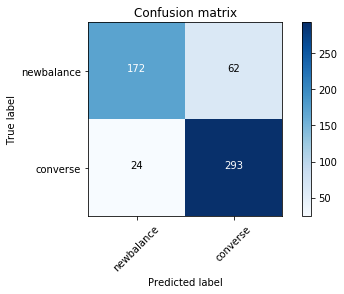

In [42]:
plot_confusion_matrix(cm, {'converse':0, 'newbalance':1})

#### note : when overfitting, newbalance are more predicted as converse

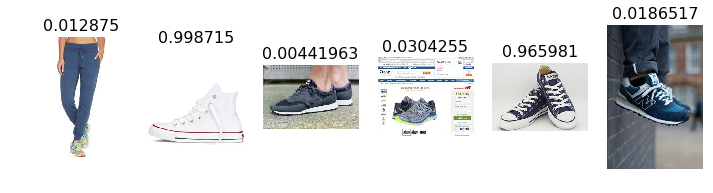

In [43]:
#print(filenames)
n_view = 6

#1. A few correct labels at random
correct = np.where(preds==val_labels[:,1])[0]
idx = permutation(correct)[:n_view]
plots_idx(idx, probs[idx])

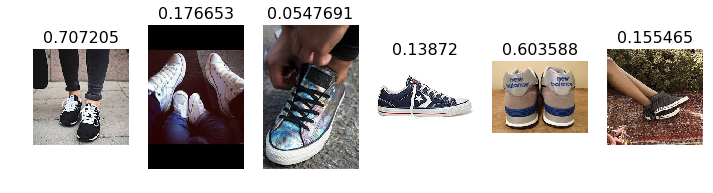

In [44]:
#2. A few incorrect labels at random
incorrect = np.where(preds!=val_labels[:,1])[0]
idx = permutation(incorrect)[:n_view]
plots_idx(idx, probs[idx])

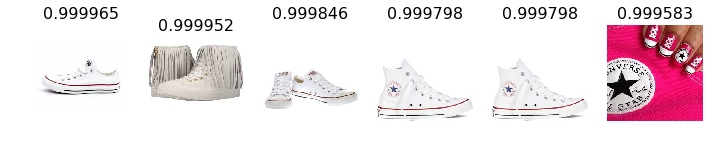

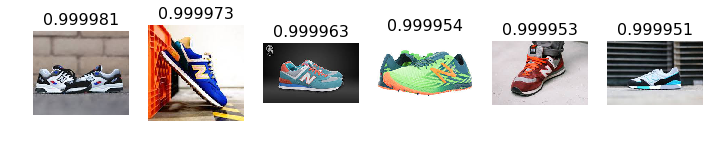

In [45]:
#3. The images we most confident were CONVERSE, and are actually CONVERSE
correct_converse = np.where((preds==0) & (preds==val_labels[:,1]))[0]
most_correct_converse = np.argsort(probs[correct_converse])[::-1][:n_view]
plots_idx(correct_converse[most_correct_converse], probs[correct_converse][most_correct_converse])

# as above, but NEW BALANCE
correct_newb = np.where((preds==1) & (preds==val_labels[:,1]))[0]
most_correct_newb = np.argsort(probs[correct_newb])[:n_view]
plots_idx(correct_newb[most_correct_newb], 1-probs[correct_newb][most_correct_newb])

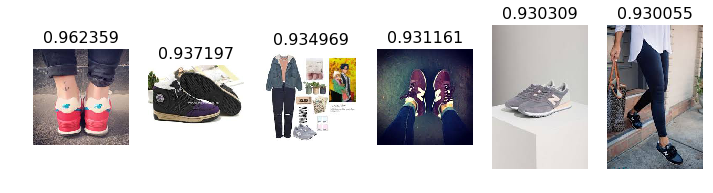

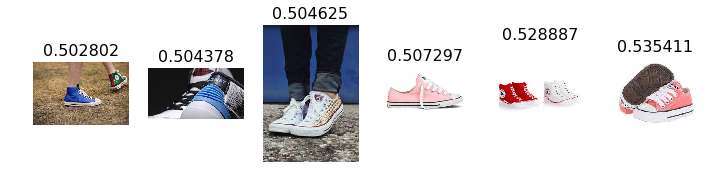

In [46]:
#4. The images we were most confident were CONVERSE, but are actually NEWBALANCE
incorrect_converse = np.where((preds==0) & (preds!=val_labels[:,1]))[0]
most_incorrect_converse = np.argsort(probs[incorrect_converse])[::-1][:n_view]
plots_idx(incorrect_converse[most_incorrect_converse], probs[incorrect_converse][most_incorrect_converse])

# as above, but NEW BALANCE
incorrect_newb = np.where((preds==1) & (preds!=val_labels[:,1]))[0]
most_incorrect_newb = np.argsort(probs[incorrect_newb])[::-1][:n_view]
plots_idx(incorrect_newb[most_incorrect_newb], 1-probs[incorrect_newb][most_incorrect_newb])

##### maybe linked to unbalanced confusion matrix, worst predict on new balance got 50% probs. no high level % = quite discriminating

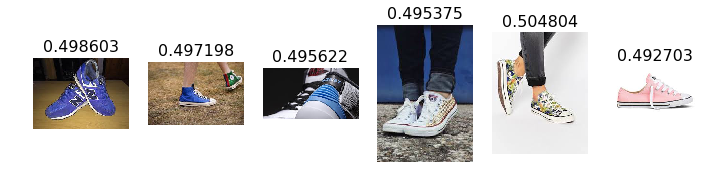

In [48]:
#5. The most uncertain labels (ie those with probability closest to 0.5).
most_uncertain = np.argsort(np.abs(probs-0.5))
plots_idx(most_uncertain[:n_view], probs[most_uncertain])

## Retraining more layers

### Training multiple layers in Keras

In [49]:
#model.load_weights(model_path+'finetune.BS128.LR0003.epoch22.h5')

In [50]:
layers = model.layers
# Get the index of the first dense layer...
first_dense_idx = [index for index,layer in enumerate(layers) if type(layer) is Dense][0]
# ...and set this and all subsequent layers to trainable
for layer in layers[first_dense_idx:]: layer.trainable=True

In [51]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_1 (Lambda)            (None, 3, 224, 224)       0         
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 3, 226, 226)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 224, 224)      1792      
_________________________________________________________________
zero_padding2d_2 (ZeroPaddin (None, 64, 226, 226)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 224, 224)      36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 112, 112)      0         
_________________________________________________________________
zero_padding2d_3 (ZeroPaddin (None, 64, 114, 114)      0         
__________

In [53]:
K.set_value(opt.lr, 0.003)
fit_model(model, batches, val_batches, 4)

Epoch 1/4
18/18 [==============================] - 47s - loss: 4.0037 - acc: 0.6386 - val_loss: 0.6474 - val_acc: 0.8294
Epoch 2/4
18/18 [==============================] - 48s - loss: 1.2587 - acc: 0.7605 - val_loss: 1.0810 - val_acc: 0.7677
Epoch 3/4
18/18 [==============================] - 48s - loss: 1.2258 - acc: 0.7678 - val_loss: 0.6776 - val_acc: 0.8258
Epoch 4/4
18/18 [==============================] - 48s - loss: 0.8992 - acc: 0.8095 - val_loss: 1.5319 - val_acc: 0.7387


In [57]:
model.save_weights(model_path+'finetune.BS128.LR003.allDenseLayers.epoch04.h5')

In [58]:
fit_model(model, batches, val_batches, 4)

Epoch 1/4
18/18 [==============================] - 48s - loss: 1.0803 - acc: 0.7959 - val_loss: 2.3893 - val_acc: 0.6806
Epoch 2/4
18/18 [==============================] - 48s - loss: 1.1666 - acc: 0.7937 - val_loss: 0.5987 - val_acc: 0.8548
Epoch 3/4
18/18 [==============================] - 49s - loss: 1.0580 - acc: 0.8106 - val_loss: 0.6377 - val_acc: 0.8403
Epoch 4/4
18/18 [==============================] - 49s - loss: 1.0826 - acc: 0.8082 - val_loss: 0.7093 - val_acc: 0.8258


In [59]:
model.save_weights(model_path+'finetune.BS128.LR003.allDenseLayers.epoch08.h5')

#### resuming point because of overfitting
lowering learning rate from 0.003 to 0.001

In [67]:
model.load_weights(model_path+'finetune.BS128.LR003.allDenseLayers.epoch08.h5')

In [68]:
K.set_value(opt.lr, 0.001)
fit_model(model, batches, val_batches, 1)

Epoch 1/1
18/18 [==============================] - 49s - loss: 0.4635 - acc: 0.8808 - val_loss: 0.4965 - val_acc: 0.8766


In [70]:
model.save_weights(model_path+'finetune.BS128.LR003-001.allDenseLayers.epoch09.h5')

In [71]:
K.set_value(opt.lr, 0.0003)
fit_model(model, batches, val_batches, 2)

Epoch 1/2
18/18 [==============================] - 48s - loss: 0.4571 - acc: 0.8817 - val_loss: 0.4948 - val_acc: 0.8766
Epoch 2/2
18/18 [==============================] - 49s - loss: 0.4628 - acc: 0.8834 - val_loss: 0.4978 - val_acc: 0.8730


#### resuming point because of overfitting
lowering learning rate from 0.003 to 0.0003

In [72]:
model.load_weights(model_path+'finetune.BS128.LR003.allDenseLayers.epoch08.h5')

In [73]:
K.set_value(opt.lr, 0.0003)
fit_model(model, batches, val_batches, 2)

Epoch 1/2
18/18 [==============================] - 48s - loss: 0.5361 - acc: 0.8716 - val_loss: 0.5495 - val_acc: 0.8584
Epoch 2/2
18/18 [==============================] - 49s - loss: 0.5267 - acc: 0.8707 - val_loss: 0.5290 - val_acc: 0.8693


In [74]:
model.save_weights(model_path+'finetune.BS128.LR003-0003.allDenseLayers.epoch10.h5')

In [77]:
model.load_weights(model_path+'finetune.BS128.LR003-0003.allDenseLayers.epoch10.h5')

In [78]:
for layer in layers[12:]: layer.trainable=True
K.set_value(opt.lr, 0.00003)

In [79]:
fit_model(model, batches, val_batches, 2)

Epoch 1/2
18/18 [==============================] - 48s - loss: 0.4727 - acc: 0.8803 - val_loss: 0.5209 - val_acc: 0.8693
Epoch 2/2
18/18 [==============================] - 49s - loss: 0.4538 - acc: 0.8840 - val_loss: 0.5192 - val_acc: 0.8693


In [80]:
model.save_weights(model_path+'finetune.BS128.LR0001.allLayers.epoch02.h5')

#### validation accuracy sticks to 0.8693, we're massively overfitting our model

You can always load the weights later and use the model to do whatever you need:

In [82]:
model.load_weights(model_path+'finetune.BS128.LR0001.allLayers.epoch02.h5')
# let's use a higher batch size (and a corresponing validation step number)
## new_batch_size = batch_size*2 =» ressources exhausted
new_batch_size = batch_size
new_validation_steps = int(np.ceil(validation_steps/2))
model.evaluate_generator(get_batches(path+'valid', gen, False, new_batch_size), new_validation_steps )

Found 551 images belonging to 2 classes.


[0.63303043444951379, 0.83854166666666663]